
# Natural Language Processing Project

## Part A

To Build a sequential NLP classifier which can use input text parameters to determine the
customer sentiments.


**Importing modules for project**

In [37]:
import numpy as np
import pandas as pd
import datetime, os
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, SpatialDropout1D

**Import and analyse the data set.**

In [38]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000,
                                                      oov_char=0)

17464789/17464789 [==============================] - 0s 0us/step


In [39]:
# review dataset
x_train.shape,y_train.shape

((25000,), (25000,))

**Perform relevant sequence adding on the data**

In [40]:
x_train = sequence.pad_sequences(x_train, maxlen=20)
x_test = sequence.pad_sequences(x_test, maxlen=20)

we truncated the review to first 20 characters to speed up training

irrespective of review word lengths, all should been truncated to 20 length, and if necessary padded with ZEROs for shorter reviews

**Perform following data analysis:**

• Print shape of features and labels

• Print value of any one feature and it's label

In [41]:
# review dataset
x_train.shape,y_train.shape

((25000, 20), (25000,))

In [42]:
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [43]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((25000, 20), (25000, 1), (25000, 20), (25000, 1))

In [44]:
# review properties of the dataset
np.min(x_train),np.max(x_train),np.min(x_test),np.max(x_test)

(0, 9999, 0, 9999)

In [45]:
np.unique(y_train),np.unique(y_test)

(array([0, 1]), array([0, 1]))

In [46]:
index = np.random.randint(0,len(x_train),size=1)[0]
print('\033[1m'+"FEATURES:"+'\033[0m')
print(x_train[index])
print('\033[1m'+"LABEL"+'\033[0m')
print(y_train[index])

FEATURES:
[1879    0   42  826 4769    0   14    9  142   25  359    8   67   21
   45    6 1345   18  259  334]
LABEL
[0]


**Decode the feature value to get original sentence**

In [47]:
# lookup dictionaries
w2id = imdb.get_word_index()
w2id.update({'not_in_here':0})
id2w = dict(zip(w2id.values(),w2id.keys()))

1641221/1641221 [==============================] - 0s 0us/step


In [48]:
index = np.random.randint(0,len(x_train),size=5)
for i in index:
    sentence = ' '.join([id2w[seq] for seq in x_train[i]])
    print('\033[1m'+"FEATURES:"+'\033[0m')
    print(sentence)
    print('\033[1m'+"LABEL"+'\033[0m')
    print(y_train[i])
    print("="*100,'\n')

FEATURES:
every hard to here she this of every everyone wwii film corruption br older as it by country known floriane
LABEL
[1]

FEATURES:
of not_in_here presents reason that with read superior most more with even break not_in_here br of not_in_here watching out ones
LABEL
[1]

FEATURES:
seems has of thought do heights was few deep in thriller korean or an br though daughter this make full
LABEL
[1]

FEATURES:
chew closing i i not_in_here there is down br smiling to death before i i as on it is background
LABEL
[0]

FEATURES:
student really it away of see die deadly br for making for these laid really it both that's in guevara
LABEL
[1]



**Design, train, tune and test a sequential model.**

In [49]:
nVocab = np.max(x_train)+1 #10000
inpSize = x_train.shape [-1]

In [50]:
logFile = "logs/hNet_tuning.har"
logDir = "logs"

In [51]:
grid = dict(embd=[8,16,32],
            lstmN=[64,96,128],
            dOut=[0.2,0.4],
            lRate=[0.1,1e-2,1e-3])

pCols = list(grid.keys())

pGrid = pd.DataFrame(columns=pCols)
for gp in [np.array([e,l,d,lr]) 
           for e in grid["embd"] 
           for l in grid["lstmN"] 
           for d in grid["dOut"] 
           for lr in grid["lRate"]]:
    dtmp = pd.DataFrame(gp.reshape(1,-1),columns=pCols)
    pGrid = pd.merge(pGrid,dtmp,how='outer',on=pCols)

pGrid["epoch"] = np.nan
pGrid.shape

(54, 5)

In [52]:
#let us define a model generating method
def senti(gridPoint):
    embd = int(gridPoint["embd"])
    lstmN = int(gridPoint["lstmN"])
    dOut = gridPoint["dOut"]
    lr = gridPoint["lRate"]
    
    global nVocab, inpSize
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # cuDNN requirements for LSTM acceleration
    lstmParams = dict(activation = 'tanh',
                      recurrent_activation = 'sigmoid',
                      recurrent_dropout = 0, 
                      unroll = False, use_bias = True)
    # model building
    model = Sequential()
    model.add(Embedding(nVocab,embd,
                        input_length=inpSize,name='Embedding'))
    model.add(SpatialDropout1D(dOut,name="DropOut"))
    model.add(LSTM(lstmN,dropout=dOut/2,name="LSTM",**lstmParams))
    model.add(Dense(1,activation='sigmoid',name="Sentiment"))
    
    # compile
    optim = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optim, metrics=["accuracy"])
    
    return model

In [53]:
# fets define a model implementer
def runs(mFunc,mName,gIndex,gridPoint,fParams,warmStart=None):
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # create model
    model = mFunc(gridPoint)
    
    global pGrid
    
    mname = mName + "_%03d_"%(gIndex) + datetime.datetime.now().strftime("%d%b_%I%M%P")
    
    # create tensorboard logs & callbacks
    log_dir = os.path.join(logDir, mname)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1, embeddings_freq=1)
    
    # update params
    fParams.update(dict(callbacks=[tensorboard_cb],verbose=0))
    
    # refit & continue epochs
    if warmStart!=None:
        model.load_weights(warmStart)
        
    # fit the model
    with tf.device('/device:GPU:0'):
        logger = model.fit(**fParams)
        
    # record results to pGrid
    pGrid.loc[gIndex,'epoch'] = len(logger.history.get('loss'))
    for key in logger.history.keys():
        pGrid.loc[gIndex,key] = logger.history.get(key)[-1]
        
    return model

In [54]:
# lets try a model at grid point 3 (arbitraily chosen)
dict(pGrid.iloc[3])

{'embd': 8.0, 'lstmN': 64.0, 'dOut': 0.4, 'lRate': 0.1, 'epoch': nan}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 DropOut (SpatialDropout1D)  (None, 20, 8)             0         
                                                                 
 LSTM (LSTM)                 (None, 64)                18688     
                                                                 
 Sentiment (Dense)           (None, 1)                 65        
                                                                 
Total params: 98,753
Trainable params: 98,753
Non-trainable params: 0
_________________________________________________________________


None

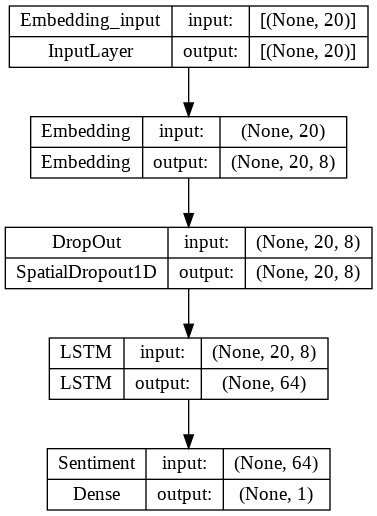

In [55]:
# trial model
s1 = senti(dict(pGrid.iloc[3]))
display(s1.summary())
plot_model(s1,show_shapes=True)

In [56]:
%%time
# trial run (base model)
fParams = dict(x=x_train,y=y_train,steps_per_epoch=200,
                 batch_size=32,epochs=20,validation_steps=100,
                 validation_data=(x_test,y_test))
s1 = runs(senti,"base",3,dict(pGrid.iloc[3]),fParams)

CPU times: user 44.7 s, sys: 4.24 s, total: 49 s
Wall time: 47.9 s


In [57]:
# Random consistency seed
np.random.seed(129)
tf.random.set_seed(129)
 
index = np.random.choice(list(pGrid.loc[pGrid.epoch.isna()].index),12,replace=False)

fParams = dict(x=x_train,y=y_train,steps_per_epoch=200,
                 batch_size=32,epochs=20,validation_steps=100,
                 validation_data=(x_test,y_test))

for i in tqdm(index,desc="hyperTuning"):
    sClf = runs(senti,"tune",i,dict(pGrid.iloc[i]),fParams)

hyperTuning: 100%|██████████| 12/12 [07:00<00:00, 35.08s/it]


In [58]:
# lets review the results
pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="val_accuracy",ascending=False).head()

,embd,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy
31,16.0,128.0,0.2,0.010,20.0,0.362171,0.846299,0.511373,0.770625
11,8.0,96.0,0.4,0.001,20.0,0.442896,0.797522,0.488761,0.770312
8,8.0,96.0,0.2,0.001,20.0,0.411427,0.814147,0.493900,0.769687
50,32.0,128.0,0.2,0.001,20.0,0.385342,0.821205,0.488715,0.769063
52,32.0,128.0,0.4,0.010,20.0,0.376794,0.829987,0.489164,0.768750


In [59]:
%%time
# lets pick the best model and train on complete dataset
i = pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="val_accuracy",ascending=False).index[0]
gp = dict(pGrid.iloc[i])
fParams = dict(x=x_train,y=y_train,batch_size=32,
               epochs=20,validation_data=(x_test,y_test))
SentiCLF = runs(senti,"FINAL",i,gp,fParams)

CPU times: user 2min 29s, sys: 13.9 s, total: 2min 43s
Wall time: 2min 23s


In [60]:
# parameterize overfitting
pGrid["overFit"] = pGrid.apply(lambda row: row["val_accuracy"]-row["accuracy"],axis=1)

In [61]:
# review based on overfitting
pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="overFit",ascending=False).head()

,embd,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy,overFit
42,32.0,96.0,0.2,0.100,20.0,0.795619,0.522428,0.765303,0.524375,0.001947
12,8.0,128.0,0.2,0.100,20.0,0.846235,0.513488,0.841127,0.498437,-0.015051
3,8.0,64.0,0.4,0.100,20.0,0.762231,0.515056,0.759748,0.488125,-0.026931
11,8.0,96.0,0.4,0.001,20.0,0.442896,0.797522,0.488761,0.770312,-0.027209
5,8.0,64.0,0.4,0.001,20.0,0.440620,0.796895,0.486981,0.767187,-0.029707


In [62]:
%%time
# lets pick the model with least overfitting & train on full dataset
j = pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="overFit",ascending=False).index[0]
gp = dict(pGrid.iloc[j])
fParams = dict(x=x_train,y=y_train,batch_size=32,
               epochs=20,validation_data=(x_test,y_test))
SentiCLF2 = runs(senti,"FINAL2",j,gp,fParams)

CPU times: user 2min 24s, sys: 13.3 s, total: 2min 37s
Wall time: 1min 59s


In [63]:
# update & review results
pGrid["overFit"] = pGrid.apply(lambda row: row["val_accuracy"]-row["accuracy"],axis=1)
pGrid.iloc[[i,j]]

,embd,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy,overFit
31,16.0,128.0,0.2,0.01,20.0,0.286768,0.88440,0.578082,0.75828,-0.12612
42,32.0,96.0,0.2,0.10,20.0,0.778573,0.53528,0.805238,0.54400,0.00872


In [64]:
# choose the better one
if pGrid.loc[i,["val_accuracy"]].values[0] > pGrid.loc[j,["val_accuracy"]].values[0]:
    fModel = SentiCLF
else:
    fModel = SentiCLF2

while only a slight improvement is found in validation accuracy between last 2 full model runs
all models fairly perform for the given limitiations of 10000 vocabulary & document cap of 20 lengths
lets use the last model to predict sentiment for few documents

**Use the designed model to print the prediction on any one sample**

In [65]:
index = np.random.randint(0,len(x_test),size=5)
pred = (fModel.predict(x_test[index])>0.5)*1
for j,i in enumerate(index):
    sentence = ' '.join([id2w[seq] for seq in x_test[i]])
    print('\033[1m'+"FEATURES:"+'\033[0m')
    print(sentence)
    print('\033[1m'+"TRUE LABEL"+'\033[0m')
    print(y_train[i])
    print('\033[1m'+"PREDICTED LABEL"+'\033[0m')
    print(pred[j])
    print("="*100,'\n')

1/1 [==============================] - 0s 371ms/step
FEATURES:
i i was painful in can as on cast not how watching part in smoking some to realistic of material
TRUE LABEL
[0]
PREDICTED LABEL
[0]

FEATURES:
way film becoming sustain in of difficult boasts better in negative not_in_here even by this could've bollywood bit that still
TRUE LABEL
[0]
PREDICTED LABEL
[0]

FEATURES:
it's his as it these is hoping you in change to time done unfortunately make am i'll to italian since
TRUE LABEL
[1]
PREDICTED LABEL
[1]

FEATURES:
film room coup boyle not_in_here not_in_here legend to adolescent not_in_here give cinema are in lost not_in_here are of not_in_here nemesis
TRUE LABEL
[1]
PREDICTED LABEL
[1]

FEATURES:
just is cena of once prior of fundamental kelly from single we offense movie of father up without wwii '
TRUE LABEL
[0]
PREDICTED LABEL
[0]



## Part B

Build a sequential NLP classifier which can use input text parameters to determine the
customer sentiments.

In [107]:
from google.colab import drive #mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input
from tensorflow.keras.layers import Dropout, Bidirectional, GRU
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import re,nltk, html
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag 
from string import punctuation
from sklearn.model_selection import train_test_split
from keras.preprocessing import text, sequence

**Read and explore the data**

In [109]:
url = 'https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json'

In [110]:
news = pd.read_json(url, lines=True)
news.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [111]:
# review the data properties
news.shape

(28619, 3)

In [112]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [113]:
# check for null/nan values
news.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [114]:
# check for support of sentiment classes
news.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

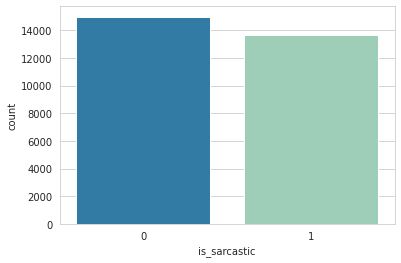

In [115]:
sns.set_style('whitegrid')
sns.countplot(x='is_sarcastic',data=news, palette='YlGnBu_r');

**Retain relevant columns**



In [116]:
df=news.copy(deep= True)

In [117]:
# drop article link
df.drop(["article_link"],axis=1,inplace=True)

**Get length of each sentence**

In [118]:
df['length of sentence'] = df.headline.apply(lambda x: len(str(x).split(' ')))
df.head()

,is_sarcastic,headline,length of sentence
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


upto 99% of the headlines are less than 20 words long

**Define parameters**

**Get indices for words**

**Create features and labels**

preprocessin the data

In [119]:
# remove unwanted characters but keep the alphanum
pattern = "[^\w ]"
df.headline = df.headline.apply(lambda s : re.sub(pattern,"",s))



In [120]:
#covert all texts in text columns into lower case
df.headline = df.headline.apply(lambda s: s.lower())

In [121]:
#remove unwanted spaces
df.headline = df.headline.apply(lambda s: s.strip())

In [122]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [123]:
stopwords = set(stopwords.words('english'))
df.headline = df.headline.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
#recheck data
df.head()

,is_sarcastic,headline,length of sentence
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep totally nails congress falling short g...,13
2,0,eat veggies 9 deliciously different recipes,7
3,1,inclement weather prevents liar getting work,8
4,1,mother comes pretty close using word streaming...,9


In [124]:
#creatin feature labels

X=df['headline'].values
y=df['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [125]:
#Define parameters, Tokenize and get indices for words
vocab_size=10000
embedding_dim=100
max_length=32
trunc_type='post'
padding_type='post'
oov_tok=''
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [126]:
#Building a dense network first
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 100)           1000000   
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                102432    
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 1)               

**Get vocabulary size**

**Create a weight matrix using GloVe embeddings**

In [127]:
vocab = set()
wordCount = 0
def wCount(doc):
    global wordCount,vocab
    doc = doc.split()
    vocab.update(doc)
    wordCount+=len(doc)

tqdm.pandas(desc="wordCount")
news.headline.progress_apply(lambda x: wCount(x));

wordCount: 100%|██████████| 28619/28619 [00:00<00:00, 334301.92it/s]


In [128]:
# counts
len(vocab),wordCount

(38234, 287620)

In [129]:
!mkdir -p dense_model_output

In [131]:
os.chdir('/content/drive/My Drive/pgpaiml/project/nlp2 project/')

In [154]:
!pwd
!ls

/content/drive/MyDrive/pgpaiml/project/nlp2 project
 dense_model_output	       'NLP FAQ - 2.pdf'
 glove.6B.zip		        nlp_project2_vinay.ipynb
'NLP-2_Problem Statement.pdf'   Sarcasm_Headlines_Dataset.json


In [155]:
!unzip 'glove.6B.zip'

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [133]:
glove_dir = '/content/drive/My Drive/pgpaiml/project/nlp2 project/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [134]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
  if i<vocab_size:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [135]:
#Adding the weights from the glove embedding
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [138]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.fit(x=training_padded, y=y_train, batch_size=256, epochs=100, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
79/79 [==============================] - 1s 8ms/step - loss: 0.7060 - accuracy: 0.5165 - val_loss: 0.6813 - val_accuracy: 0.5877
Epoch 2/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.5418 - val_loss: 0.6737 - val_accuracy: 0.6165
Epoch 3/100
79/79 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.5617 - val_loss: 0.6630 - val_accuracy: 0.6400
Epoch 4/100
79/79 [==============================] - 0s 5ms/step - loss: 0.6663 - accuracy: 0.5878 - val_loss: 0.6496 - val_accuracy: 0.6543
Epoch 5/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6531 - accuracy: 0.6098 - val_loss: 0.6337 - val_accuracy: 0.6776
Epoch 6/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6401 - accuracy: 0.6285 - val_loss: 0.6191 - val_accuracy: 0.6943
Epoch 7/100
79/79 [==============================] - 0s 5ms/step - loss: 0.6318 - accuracy: 0.6386 - val_loss: 0.6080 - val_accuracy: 0.7078
Epoch 8/100
7

In [140]:
df_m=pd.DataFrame(model.history.history)
df_m['Epoch']=range(1,44)
df_m.index=df_m['Epoch']
df_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.705996,0.516548,0.681309,0.587701,1
2,0.687982,0.541806,0.673732,0.616469,2
3,0.676928,0.561673,0.663003,0.639995,3
4,0.666344,0.587830,0.649621,0.654321,4
5,0.653110,0.609794,0.633679,0.677615,5
6,0.640084,0.628463,0.619117,0.694270,6
7,0.631778,0.638646,0.607991,0.707780,7
8,0.619122,0.651675,0.594963,0.714885,8
9,0.605687,0.666800,0.581873,0.724668,9


In [141]:
score = model.evaluate(testing_padded, y_test, batch_size=64, verbose=1)
print('Test accuracy:', score[1])

135/135 [==============================] - 1s 5ms/step - loss: 0.4391 - accuracy: 0.8031
Test accuracy: 0.8030514717102051


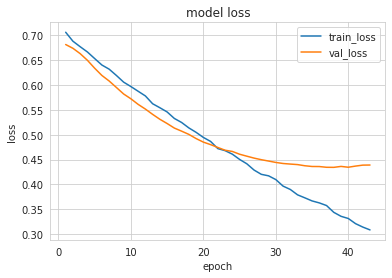

In [142]:
#Loss Graph(Training and Validation)
plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [143]:
#building CNN model
model_conv = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(16,3,activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [144]:
model_conv.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 16)            4816      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 16)           0         
 )                                                               
                                                                 
 dropout_6 (Dropout)         (None, 15, 16)            0         
                                                                 
 flatten_3 (Flatten)         (None, 240)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 1446      
                                                     

In [145]:
model_conv.layers[0].set_weights([embedding_matrix])
model_conv.layers[0].trainable = False
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model_conv.fit(training_padded, y_train, batch_size=256, epochs=20, validation_data=(testing_padded, y_test), callbacks=[early_stop])

Epoch 1/20
79/79 [==============================] - 6s 8ms/step - loss: 0.6773 - accuracy: 0.5670 - val_loss: 0.6357 - val_accuracy: 0.6514
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 0.6003 - accuracy: 0.6788 - val_loss: 0.5628 - val_accuracy: 0.7170
Epoch 3/20
79/79 [==============================] - 0s 5ms/step - loss: 0.5517 - accuracy: 0.7214 - val_loss: 0.5333 - val_accuracy: 0.7363
Epoch 4/20
79/79 [==============================] - 0s 5ms/step - loss: 0.5226 - accuracy: 0.7423 - val_loss: 0.5175 - val_accuracy: 0.7496
Epoch 5/20
79/79 [==============================] - 0s 5ms/step - loss: 0.5086 - accuracy: 0.7522 - val_loss: 0.5073 - val_accuracy: 0.7545
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 0.4955 - accuracy: 0.7595 - val_loss: 0.5002 - val_accuracy: 0.7596
Epoch 7/20
79/79 [==============================] - 0s 5ms/step - loss: 0.4840 - accuracy: 0.7631 - val_loss: 0.4961 - val_accuracy: 0.7615
Epoch 8/20
79/79 [==

**Define and compile a Bidirectional LSTM model.**

In [146]:
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [147]:
model_lstm.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 100)           1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
 dense_12 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,034,445
Trainable params: 1,034,445
Non-trainable params: 0
_________________________________________________________________


In [148]:
model_lstm.layers[0].set_weights([embedding_matrix])
model_lstm.layers[0].trainable = False

In [150]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


**Fit the model and check the validation accuracy**

In [151]:
history_lstm = model_lstm.fit(x=training_padded, y=y_train, batch_size=64, epochs=100, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
314/314 [==============================] - 7s 12ms/step - loss: 0.2667 - accuracy: 0.8877 - val_loss: 0.4527 - val_accuracy: 0.8036
Epoch 2/100
314/314 [==============================] - 3s 9ms/step - loss: 0.2417 - accuracy: 0.8991 - val_loss: 0.4977 - val_accuracy: 0.7957
Epoch 3/100
314/314 [==============================] - 3s 9ms/step - loss: 0.2242 - accuracy: 0.9086 - val_loss: 0.4635 - val_accuracy: 0.8008
Epoch 4/100
314/314 [==============================] - 3s 11ms/step - loss: 0.2042 - accuracy: 0.9182 - val_loss: 0.5040 - val_accuracy: 0.7984
Epoch 5/100
314/314 [==============================] - 4s 11ms/step - loss: 0.1842 - accuracy: 0.9280 - val_loss: 0.5399 - val_accuracy: 0.7992
Epoch 6/100
314/314 [==============================] - 3s 9ms/step - loss: 0.1663 - accuracy: 0.9328 - val_loss: 0.5516 - val_accuracy: 0.7955
Epoch 6: early stopping


In [152]:
score = model_lstm.evaluate(testing_padded, y_test, batch_size=64, verbose=1)
print('Test accuracy:', score[1])

135/135 [==============================] - 1s 4ms/step - loss: 0.5516 - accuracy: 0.7955
Test accuracy: 0.7954810261726379


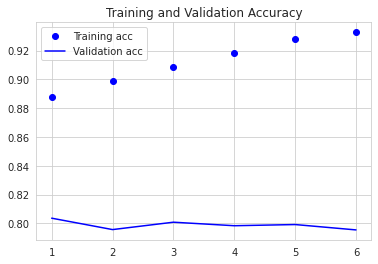

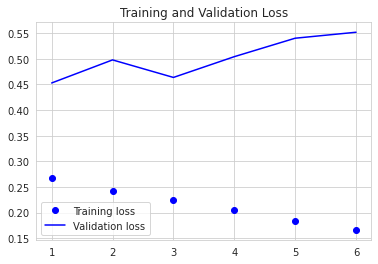

In [153]:
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

This model did not perform very well compared to the other base models. One particular reason is that my inputs only consider first 32 words, rather than full sequences. Another reason may be not experimenting much with the embedding dimensionality or the LSTM output. Another reason can be the lesser try with regularization. However, the primary reason here is that analyzing the global long term structure of the reviews isn't helpful in solving the problem.